In [1]:
import numpy as np
import torch
from collections import Counter
# model
from models import GCNEdgeClassifier
# val
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef
# plot
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn

In [2]:
plt.style.use('seaborn-whitegrid')

## Data

In [3]:
fold_idx = 2

In [4]:
train_data = torch.load(f'../../data/graph_designer/train_test_edge_classification_days/train_data_{fold_idx}.pt')
test_data  = torch.load(f'../../data/graph_designer/train_test_edge_classification_days/test_data_{fold_idx}.pt')
train_data 

Data(x=[2812, 7], edge_index=[2, 3364], edge_attr=[3364, 1], edge_label=[3364, 2])

In [5]:
test_data

Data(x=[2812, 7], edge_index=[2, 841], edge_attr=[841, 1], edge_label=[841, 2])

In [6]:
# 0: alto, 1: baixo
Counter(train_data.edge_label.argmax(dim=1).numpy())

Counter({1: 1705, 0: 1659})

In [7]:
# 0: alto, 1: baixo
Counter(test_data.edge_label.argmax(dim=1).numpy())

Counter({0: 391, 1: 450})

In [8]:
train_data.edge_label = train_data.edge_label.argmax(dim=1).view(-1)
test_data.edge_label = test_data.edge_label.argmax(dim=1)

In [9]:
train_data.edge_label.shape

torch.Size([3364])

In [10]:
#train_data.edge_label

In [11]:
#train_data.edge_label.resize(train_data.edge_label.size(), 1)

## Model

In [12]:
# class GCNEdgeClassifier(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(GCNEdgeClassifier, self).__init__()
#         self.conv1 = gnn.GCNConv(in_channels, hidden_channels)
#         #self.conv2 = gnn.GCNConv(hidden_channels, hidden_channels)
#         self.classifier = nn.Linear(2 * hidden_channels, out_channels)

#     def forward(self, x, edge_index, w):
#         # Node embeddings
#         x = self.conv1(x, edge_index, w)
#         x = F.relu(x)
#         #x = self.conv2(x, edge_index, w)
        
#         # Edge embeddings
#         row, col = edge_index
#         edge_embeddings = torch.cat([x[row], x[col]], dim=-1)
        
#         #x = nn.Sigmoid(edge_embeddings)
        
#         # Edge classification
#         # return self.classifier(x)
#         return self.classifier(edge_embeddings)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNEdgeClassifier(train_data.num_features, 64, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1, factor=0.5)
m = nn.Sigmoid()
model

GCNEdgeClassifier(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
train_data.edge_attr.max()

tensor(6.0866)

In [15]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x.to(device), 
                train_data.edge_index.to(device),
                train_data.edge_attr.to(device))
    
    x_sig = m(out.view(-1))
    loss = criterion(x_sig, train_data.edge_label.to(device).flatten().float())
    
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    predicted = (x_sig > 0.5).float()  # Assuming binary classification threshold
    correct = (predicted == train_data.edge_label.to(device).flatten().float()).sum().item()
    total = train_data.edge_label.size(0)
    accuracy = correct / total
    
    return loss.item(), accuracy

In [16]:
def test(data, tresh=0.3):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), 
                    data.edge_index.to(device),
                    data.edge_attr.to(device))
        x_sig = m(out.view(-1))
        
        # pred = out.argmax(dim=1)
        # true = data.edge_label.to(device).argmax(dim=1)
        
        pred = [0 if x < tresh else 1 for x in x_sig]
        true = data.edge_label.to(device).cpu().numpy()#.argmax(dim=1)
        
        return true, pred 

In [17]:
train_data.edge_label.to(device).flatten()

tensor([1, 1, 1,  ..., 1, 1, 1])

### Train

In [18]:
scores_los = []
scores_acc = []

In [19]:
#loss_scores = [train() for _ in range(30)]
#scores = [train() for _ in range(30)]
for _ in range(50):
    score_loss, score_acc = train()
    
    #scheduler.step(score_acc)
    
    scores_los.append(score_loss)
    scores_acc.append(score_acc)

In [20]:
#scores = np.array(scores)
# score_los = scores[:,0]
# score_acc = scores[:,1]

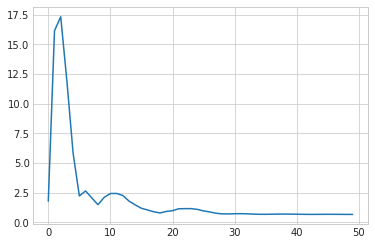

In [21]:
plt.plot(scores_los)
plt.show()

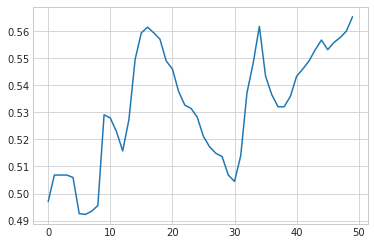

In [22]:
plt.plot(scores_acc)
plt.show()

### Test

In [31]:
y_true, y_pred = test(test_data, 0.5111)

### Validation

In [32]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute MCC
mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)

Confusion Matrix:
[[190 201]
 [169 281]]
MCC: 0.11130283060443621


In [33]:
accuracy = accuracy_score(y_true, y_pred) 
prec     = precision_score(y_true, y_pred, average='binary')
rec      = recall_score(y_true, y_pred, average='binary')
f1       = f1_score(y_true, y_pred, average='binary')

accuracy, prec, rec, f1

(0.5600475624256838, 0.58298755186722, 0.6244444444444445, 0.6030042918454936)

Classes:  Counter({1: 450, 0: 391})


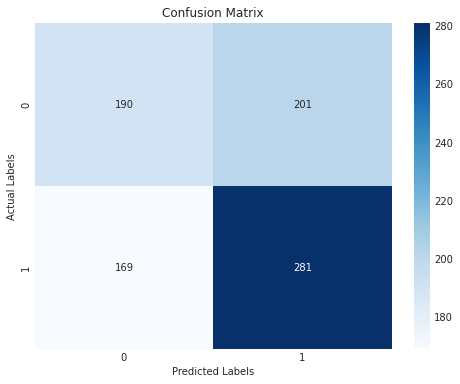

In [34]:
# Create a heatmap plot of the confusion matrix
#keys = Counter(y_true.numpy())
keys = Counter(y_true)
print(f"Classes:  {keys}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=sorted(keys.keys()), 
            yticklabels=sorted(keys.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()